In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Classification Using CNN (second  classify (Tomato))
By : Amira Fathy

________


Data link : https://www.kaggle.com/datasets/sadmansakibmahi/plant-disease-expert


**Libraries**

In [2]:
## import libraries

import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import keras
import pandas as pd
import os
import glob as gb
from zipfile import ZipFile

In [3]:
# the path of zip file

path_file= r'/content/drive/MyDrive/Colab Notebooks/tomato.zip'

In [ ]:
# extract zip file

with ZipFile(path_file,'r')as Zip:
  Zip.printdir()
  Zip.extractall()

In [5]:
# path of image

data_path= r'/content/tomato'

# get the common size in images
# and the number of the images in each folder
Size=[]

for folder in os.listdir(data_path) :
    files = gb.glob(pathname= str( data_path +'/'+ folder + '/*.JPG'))
    print(f' found  {len(files)}  images in folder {folder}')
    for file in files:
        image = plt.imread(file)
        Size.append(image.shape)
pd.Series(Size).value_counts()

 found  1404  images in folder Tomato__Target_Spot
 found  1676  images in folder Tomato_Spider_mites_Two_spotted_spider_mite
 found  952  images in folder Tomato_Leaf_Mold
 found  3208  images in folder Tomato__Tomato_YellowLeaf__Curl_Virus
 found  2127  images in folder Tomato_Bacterial_spot
 found  1771  images in folder Tomato_Septoria_leaf_spot
 found  1756  images in folder Tomato_Late_blight
 found  1590  images in folder Tomato_healthy
 found  373  images in folder Tomato__Tomato_mosaic_virus
 found  1000  images in folder Tomato_Early_blight


(256, 256, 3)    15857
dtype: int64

The distribution  of images  not good  
 we have just 373 Tomato__Tomato_mosaic_virus

 and 952  Tomato_Leaf_Mold

In [6]:
# initializing value
BATCH_SIZE = 128
IMAGE_SIZE = 150
CHANNELS=3
EPOCHS=50

In [7]:
# load images  by keras
dataset =tf.keras.preprocessing.image_dataset_from_directory(data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [8]:
# class names
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(128, 150, 150, 3)
[0 4 4 6 9 0 8 5 9 6 7 1 7 9 6 5 0 7 0 0 7 5 7 2 2 7 7 1 7 8 9 7 4 5 5 6 1
 5 9 7 2 4 6 6 4 4 2 5 5 7 5 7 5 1 0 5 6 0 4 7 0 0 9 6 1 3 4 0 2 2 7 5 0 7
 7 0 4 0 7 1 2 6 0 3 0 2 0 0 1 3 7 2 2 3 9 7 7 7 0 7 7 6 3 6 1 4 6 4 0 7 5
 3 2 9 4 1 7 7 7 5 9 7 7 4 7 3 6 9]


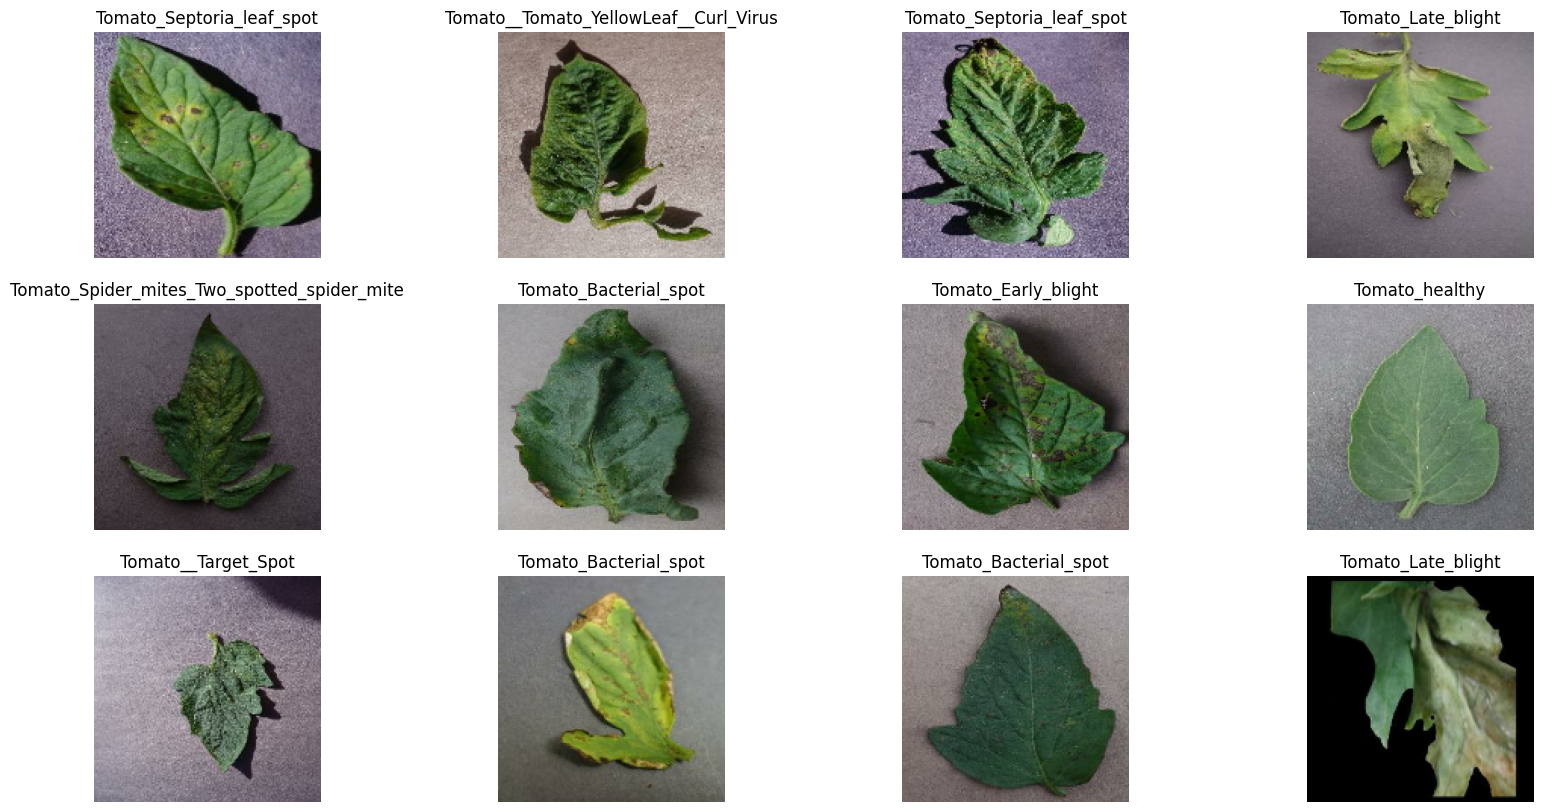

In [10]:
# show some of image
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
# len of  dataset
len(dataset)


126

In [12]:
#  function to split data (train , test, validation)
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [13]:
# split data
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [14]:
len(train_ds),len(val_ds),len(test_ds)

(100, 12, 14)

In [ ]:
# to use the cpu & gpu
#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
#test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# normalization data
# resize & rescale
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])


In [ ]:
# data augmentation (ImageDataGenerator)
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)
#.prefetch(buffer_size=tf.data.AUTOTUNE)


In [16]:
# bulid the CNN (Neural Network )
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
   # layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 150, 150, 3)        0         
                                                                 
 conv2d (Conv2D)             (128, 148, 148, 128)      3584      
                                                                 
 max_pooling2d (MaxPooling2D  (128, 74, 74, 128)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (128, 72, 72, 64)         73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (128, 36, 36, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (128, 34, 34, 64)        

In [18]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
#train CNN
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/50
100/100 [==============================] - 66s 343ms/step - loss: 1.4759 - accuracy: 0.5023 - val_loss: 0.8606 - val_accuracy: 0.7103
Epoch 2/50
100/100 [==============================] - 43s 297ms/step - loss: 0.6862 - accuracy: 0.7685 - val_loss: 0.5984 - val_accuracy: 0.8047
Epoch 3/50
100/100 [==============================] - 50s 373ms/step - loss: 0.4983 - accuracy: 0.8264 - val_loss: 0.4081 - val_accuracy: 0.8600
Epoch 4/50
100/100 [==============================] - 42s 296ms/step - loss: 0.3654 - accuracy: 0.8726 - val_loss: 0.3191 - val_accuracy: 0.8776
Epoch 5/50
100/100 [==============================] - 42s 295ms/step - loss: 0.2940 - accuracy: 0.9017 - val_loss: 0.2246 - val_accuracy: 0.9271
Epoch 6/50
100/100 [==============================] - 42s 297ms/step - loss: 0.2329 - accuracy: 0.9205 - val_loss: 0.1324 - val_accuracy: 0.9609
Epoch 7/50
100/100 [==============================] - 48s 367ms/step - loss: 0.2183 - accuracy: 0.9271 - val_loss: 0.2047 - val_ac

In [21]:
# acuuracy of the test
scores = model.evaluate(test_ds)


14/14 [==============================] - 14s 52ms/step - loss: 1.5558e-04 - accuracy: 1.0000


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

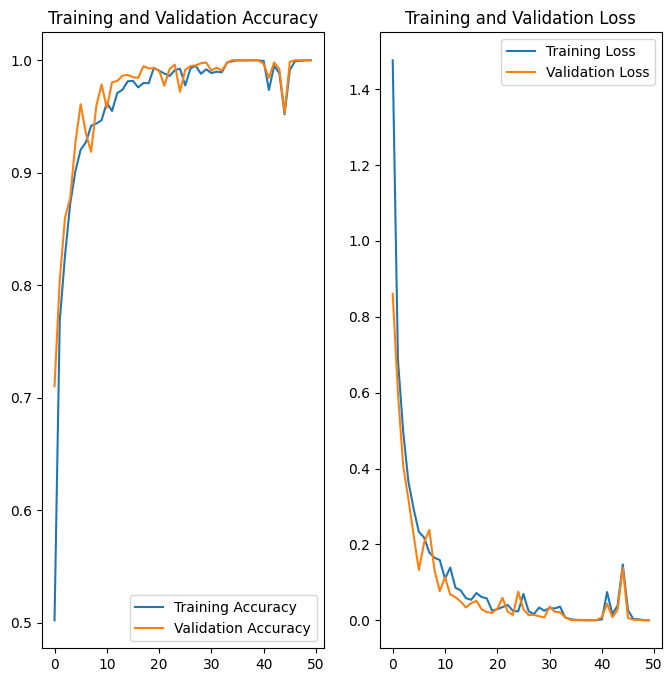

In [23]:
# show the  training & validation (accuracy & loss)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_Early_blight
4/4 [==============================] - 1s 11ms/step
predicted label: Tomato_Early_blight


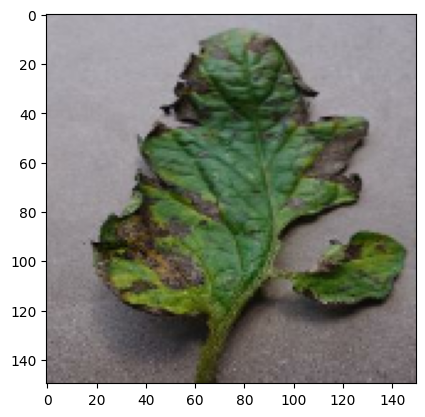

In [24]:
# the first image prdiction  vs the actual
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)

    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


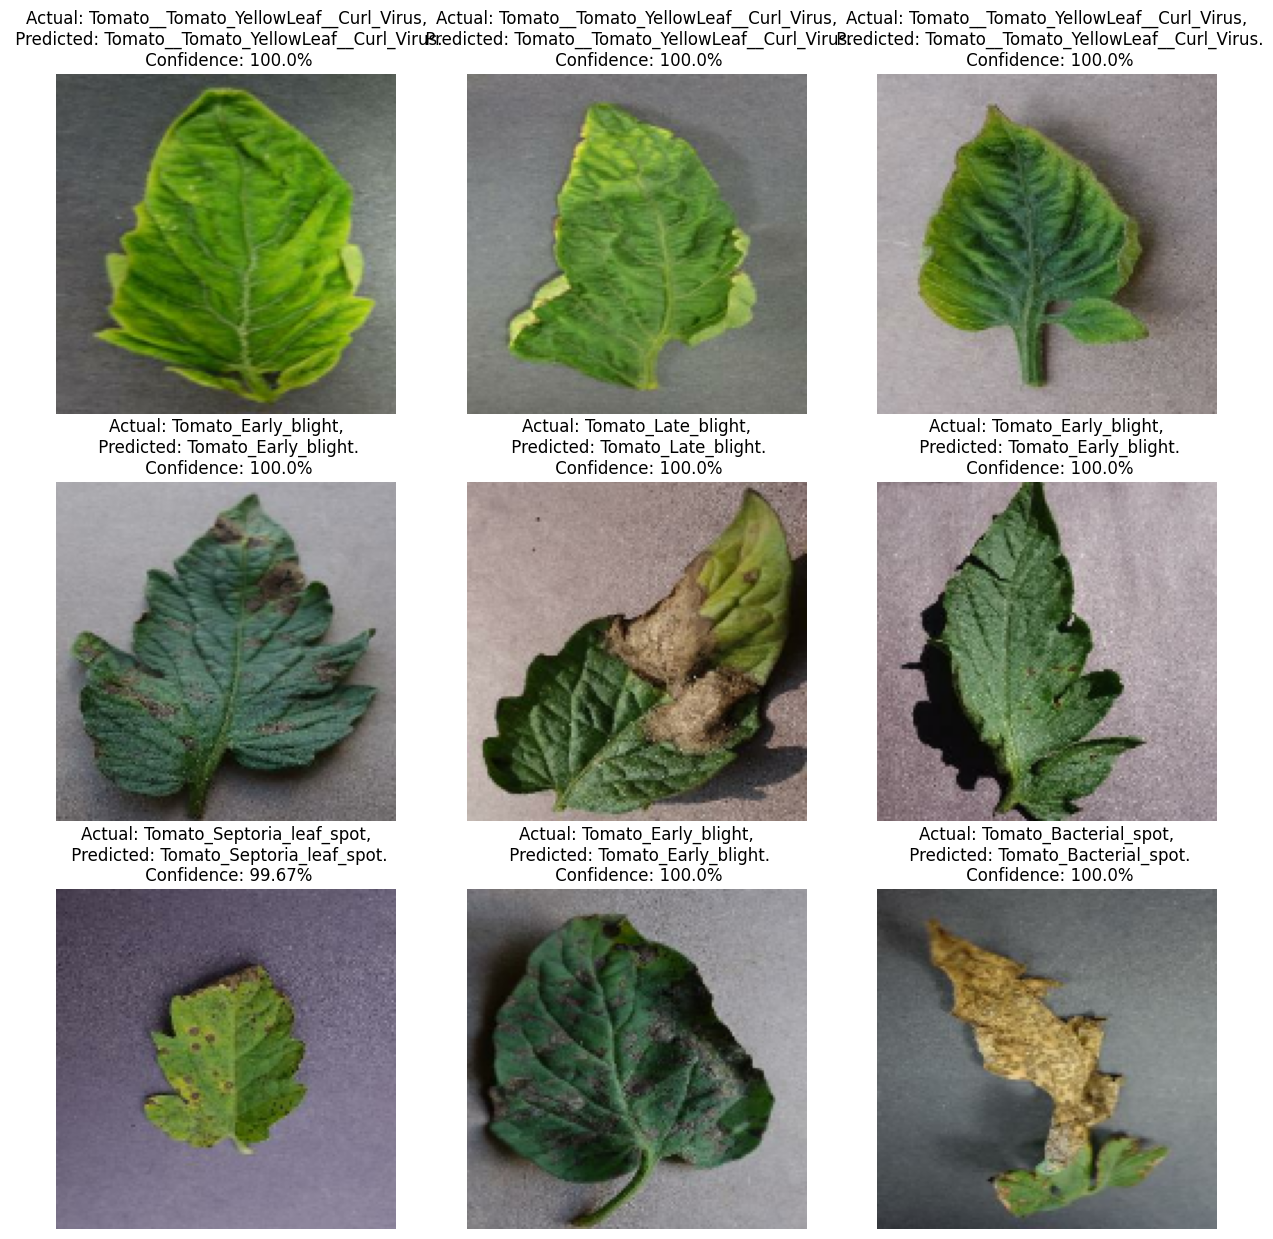

In [26]:
# show some of image  ( the prediction  vs actual )& the confidence
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [27]:
# save model
model.save("Tomato_cnn.h5")